# Advanced Topics

This notebook presents examples for *partially and delayed labeling data*, *anomaly detection* and *clustering*. 

---

### CapyMOA 

* More information about CapyMOA can be found in: [https://github.com/adaptive-machine-learning/CapyMOA](https://github.com/adaptive-machine-learning/CapyMOA)

* _If you find CapyMOA useful, considering starring the project and joining the Discord channel!_

* **KDD 2024 tutorial** by [Heitor Murilo Gomes](https://heitorgomes.com/) and [Albert Bifet](https://albertbifet.com/). Barcelona, Spain (26/08/2024), 

**Code examples are based on CapyMOA v0.7.0 as of 08/08/2024**

## 1. Anomaly Detection

* We now turn our attention to the application of anomaly detection algorithms using CapyMOA
* CapyMOA includes 3 anomaly detection algorithms: `HalfSpaceTrees`, `Autoencoder` and `Online Isolation Forest`
* `Online Isolation Forest` is a quite recent algorithm that [appeared a few days ago in ICML 2024](https://icml.cc/virtual/2024/poster/34674)


### 1.1. Creating simple anomalous data with `sklearn`

* Generating a few examples and some simple anomalous data using `sklearn`

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from capymoa.stream import NumpyStream, Schema
from capymoa.instance import LabeledInstance, RegressionInstance

# generate normal data points
n_samples = 1000
n_features = 2
n_clusters = 3
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)

# generate anomalous data points
n_anomalies = 50
anomalies = np.random.uniform(low=-10, high=10, size=(n_anomalies, n_features))

# combine the normal data points with anomalies
X = np.vstack([X, anomalies])
y = np.hstack([y, [1]*n_anomalies])  # Label anomalies with 1
y[:n_samples] = 0  # Label normal points with 0

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.show()

# create a NumpyStream from the combined dataset
feature_names = [f"feature_{i}" for i in range(n_features)]
target_name = "class"

## 1.2 IsolationForest (Batch version)

* The following code simply run the traditional `IsolationForest` algorithm using our data.
* This serves the purpose of being a simple baseline

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

# Fit Isolation Forest model
iso_forest = IsolationForest(contamination=n_anomalies / (n_samples + n_anomalies), random_state=42)
iso_forest.fit(X)

# Predict anomaly scores
scores = -iso_forest.decision_function(X)  # The lower, the more abnormal

# Calculate AUC
auc = roc_auc_score(y, scores)
print(f"AUC for batch Isolation Forest: {auc:.2f}")

### 1.3 HalfSpace Trees example

* CapyMOA is very flexible, we take this opportunity to show how to transform data generated with `sklearn` to a `Stream` object
  * The only step needed is to create the `NumpyStream` object from `X` and `y`
* Instead of using evaluation functions, we first use a basic **test-then-train loop** from scratch to evaluate the model's performance.
* Notice that lower scores indicate higher anomaly likelihood.

In [ ]:
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import AnomalyDetectionEvaluator

stream_ad = NumpyStream(X, y, dataset_name="AnomalyDetectionDataset", feature_names=feature_names, target_name=target_name)

# Print the schema
print("Schema:", stream_ad.get_schema())

learner = HalfSpaceTrees(schema=stream_ad.get_schema())
evaluator = AnomalyDetectionEvaluator(schema=stream_ad.get_schema())

while stream_ad.has_more_instances():
    instance = stream_ad.next_instance()
    score = learner.score_instance(instance)
    # print(f"label: {instance.y_index}, score: {score}")
    evaluator.update(instance.y_index, score)
    learner.train(instance)
    
auc = evaluator.auc()
print(f"HalfSpace Trees AUC: {auc:.2f}")

### 1.4 ```prequential_evaluation_anomaly```

* In this example, we use the ```prequential_evaluation_anomaly``` function with ```plot_windowed_results``` to plot AUC
* We use the Electricity data (usually a classification dataset).
* `HalfSpaceTrees`, `Autoencoder` and `Online Isolation Forest (OIF)` are used. 

In [ ]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.datasets import Electricity
from capymoa.anomaly import HalfSpaceTrees, Autoencoder, OnlineIsolationForest
from capymoa.evaluation import prequential_evaluation_anomaly


stream = Electricity()
hst = HalfSpaceTrees(schema=stream.get_schema())
ae = Autoencoder(schema=stream.get_schema())
oif = OnlineIsolationForest(schema=stream.get_schema(), num_trees=10)

results_hst = prequential_evaluation_anomaly(stream=stream, learner=hst, window_size=4500)
results_ae = prequential_evaluation_anomaly(stream=stream, learner=ae, window_size=4500)
results_oif = prequential_evaluation_anomaly(stream=stream, learner=oif, window_size=4500)

# display(results_hst.windowed.metrics_per_window())
# display(results_ae.windowed.metrics_per_window())
# display(results_oif.windowed.metrics_per_window())

print(f"[HalfSpaceTrees] AUC: {results_hst.auc()} wallclock: {results_hst.wallclock()}")
print(f"[Autoencoder] AUC: {results_ae.auc()} wallclock: {results_ae.wallclock()}")
print(f"[Online Isolation Forest] AUC: {results_oif.auc()} wallclock: {results_oif.wallclock()}")

# Display all results
plot_windowed_results(results_hst, results_ae, results_oif, metric="auc")

## 2. Partially and delayed labeling data

* This example uses the OSNN algorithm to learn from a stream with only 1% labeled data
* We use the `prequential_ssl_evaluation()` function which simulates the absence of some labels (`label_probability`) and delays (`delay_length`)
* The results yield by `prequential_ssl_evaluation()` include more information in comparison to `prequential_evaluation()`, such as the number of unlabeled instances (`unlabeled`) and the unlabeled ratio (`unlabeled_ratio`).

### 2.1 Executing and assessing

* We use the OSNN algorithm for this example
* The evaluation is quite similar to using a classifier or regressor, but `prequential_ssl_evaluation` adds `label_probability` to simulate the absence of some labels.
* This experiment might take up to 50 seconds to run (depends on the machine). 

Cumulative accuracy: 59.3 and wallclock: 51.71188497543335
Other relevant metrics for SSL problems: {'unlabeled': 990, 'unlabeled_ratio': 0.989010989010989}


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,100.0,34.0,0.000000,-340.000000,-112.903226,NaN,50.746269,NaN,NaN,34.000000,NaN,50.000000,100.000000,0.000000
1,200.0,65.0,0.000000,-150.000000,41.666667,NaN,78.787879,NaN,NaN,65.000000,NaN,50.000000,100.000000,0.000000
2,300.0,62.0,-23.136747,-216.666667,-2.702703,38.271605,NaN,76.543210,37.349398,0.000000,74.698795,39.240506,0.000000,78.481013
3,400.0,63.0,3.242678,-236.363636,44.776119,62.922136,77.018634,5.128205,81.313131,62.626263,100.000000,51.315789,100.000000,2.631579
4,500.0,45.0,-4.009077,-358.333333,-5.769231,31.034483,62.068966,NaN,22.959184,45.918367,0.000000,47.872340,95.744681,0.000000
5,600.0,47.0,6.952247,-278.571429,-51.428571,55.070599,54.700855,36.144578,55.967450,40.506329,71.428571,54.202037,84.210526,24.193548
6,700.0,57.0,2.890696,-138.888889,14.000000,51.548932,68.613139,31.746032,51.754386,61.842105,41.666667,51.345103,77.049180,25.641026
7,800.0,78.0,54.337900,-29.411765,48.837209,77.384628,81.666667,72.500000,78.078078,77.777778,78.378378,76.703386,85.964912,67.441860
8,900.0,58.0,17.808219,-121.052632,22.222222,59.376801,55.319149,60.377358,59.562842,66.666667,52.459016,59.191919,47.272727,71.111111
9,1000.0,84.0,67.793881,-100.000000,68.000000,83.896940,85.185185,82.608696,83.896940,85.185185,82.608696,83.896940,85.185185,82.608696


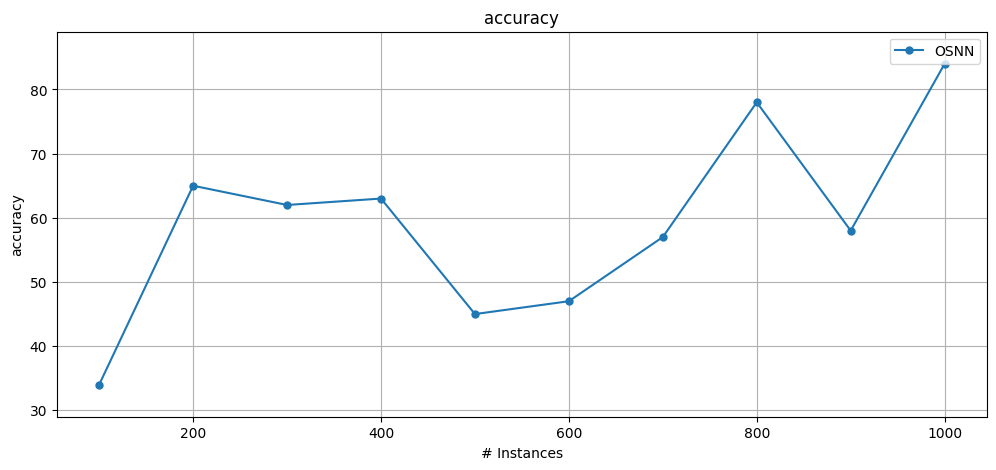

In [1]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_ssl_evaluation
from capymoa.datasets import Electricity

# In case you are curious about the prequential_ssl_evaluation function: 
# help(prequential_ssl_evaluation)

from capymoa.ssl.classifier import OSNN

stream = Electricity()

osnn = OSNN(schema=stream.get_schema())

results_osnn = prequential_ssl_evaluation(stream=stream, learner=osnn, label_probability=0.01, window_size=100, max_instances=1000)

print(f"Cumulative accuracy: {results_osnn.cumulative.accuracy()} and wallclock: {results_osnn.wallclock()}")
print(f"Other relevant metrics for SSL problems: {results_osnn.other_metrics()}")

display(results_osnn.windowed.metrics_per_window())

results_osnn.learner = "OSNN"
plot_windowed_results(results_osnn, metric='accuracy')

### 2.2 Using a supervised model and comparison (SSL vs supervised)

* If a supervised classifier is used with `prequential_ssl_evaluation()` it will only be trained on the labeled data
* It is important to assess the predictive performance of `strong` supervised methods trained only on the labeled data against new `SSL` methods

See more about challenges concerning evaluation on [A survey on semi-supervised learning for delayed partially labelled data streams](https://dl.acm.org/doi/pdf/10.1145/3523055)

[OSNN] Cumulative accuracy: 59.3 and wallclock: 51.71188497543335
[SRP100] Cumulative accuracy: 49.2 and wallclock: 0.5831742286682129


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,100.0,34.0,0.000000,-340.000000,-112.903226,NaN,50.746269,NaN,NaN,34.000000,NaN,50.000000,100.000000,0.000000
1,200.0,65.0,0.000000,-150.000000,41.666667,NaN,78.787879,NaN,NaN,65.000000,NaN,50.000000,100.000000,0.000000
2,300.0,21.0,0.000000,-558.333333,-113.513514,NaN,34.710744,NaN,NaN,21.000000,NaN,50.000000,100.000000,0.000000
3,400.0,62.0,0.000000,-245.454545,43.283582,NaN,76.543210,NaN,NaN,62.000000,NaN,50.000000,100.000000,0.000000
4,500.0,50.0,5.338887,-316.666667,3.846154,61.726883,65.277778,10.714286,74.226804,48.453608,100.000000,52.830189,100.000000,5.660377
5,600.0,33.0,-13.790761,-378.571429,-91.428571,36.124491,46.400000,10.666667,32.051282,33.333333,30.769231,41.383701,76.315789,6.451613
6,700.0,52.0,-5.773468,-166.666667,4.000000,47.031820,63.636364,29.411765,46.818844,59.154930,34.482759,47.246742,68.852459,25.641026
7,800.0,66.0,23.181202,-100.000000,20.930233,69.358327,77.027027,34.615385,81.318681,62.637363,100.000000,60.465116,100.000000,20.930233
8,900.0,55.0,0.881057,-136.842105,16.666667,51.480608,70.198675,8.163265,52.604167,55.208333,50.000000,50.404040,96.363636,4.444444
9,1000.0,54.0,0.000000,-475.000000,8.000000,NaN,70.129870,NaN,NaN,54.000000,NaN,50.000000,100.000000,0.000000


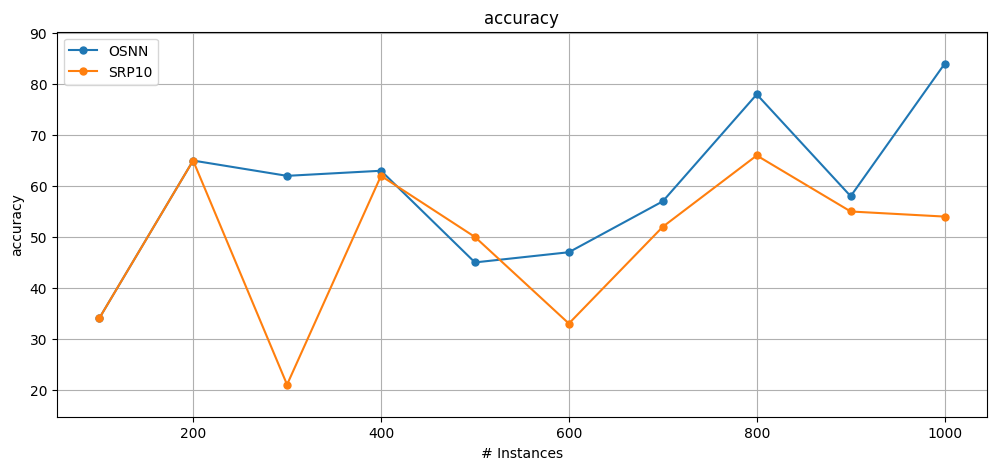

In [2]:
from capymoa.classifier import StreamingRandomPatches

srp100 = StreamingRandomPatches(schema=stream.get_schema(), ensemble_size=100)

results_srp100 = prequential_ssl_evaluation(stream=stream, learner=srp100, label_probability=0.01, window_size=100, max_instances=1000)

print(f"[OSNN] Cumulative accuracy: {results_osnn.cumulative.accuracy()} and wallclock: {results_osnn.wallclock()}")
print(f"[SRP100] Cumulative accuracy: {results_srp100.cumulative.accuracy()} and wallclock: {results_srp100.wallclock()}")
display(results_srp100.windowed.metrics_per_window())

# Plotting all the results together
# Modifying the default learner string to the results allows controlling the legend of each learner. 
results_osnn.learner = 'OSNN'
results_srp100.learner = 'SRP10'

plot_windowed_results(results_osnn, results_srp100, metric='accuracy')

## 2.3 Delay example

* Comparing the effect of delay on a stream.
  * We run the same learner (`HoeffdingTree`) twice, such that the second time around it is trained with a delay of `5,000` instances. 
  * It is interesting to see the effect after a drift takes place. 

Accuracy immediate: 86.47399999999999
Accuracy delayed by 1000 instances: 83.664


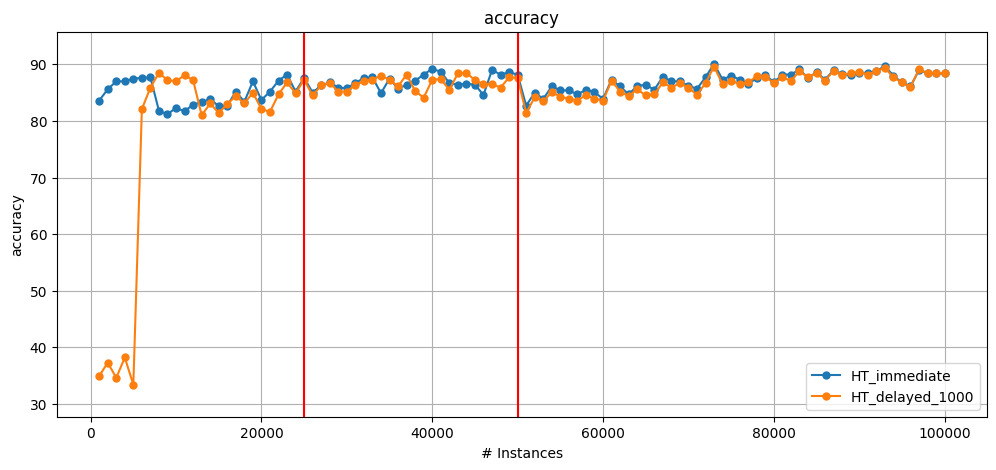

In [7]:
from capymoa.stream.generator import SEA
from capymoa.stream.drift import *
from capymoa.classifier import HoeffdingTree
from capymoa.evaluation import prequential_evaluation, prequential_ssl_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

## Creating a stream with drift
sea2drifts = DriftStream(stream=[SEA(function=1), 
                                 AbruptDrift(position=25000), 
                                 SEA(function=2), 
                                 AbruptDrift(position=50000), 
                                 SEA(function=3)])


ht_immediate = HoeffdingTree(schema=sea2drifts.get_schema())
ht_delayed = HoeffdingTree(schema=sea2drifts.get_schema())

results_ht_immediate = prequential_ssl_evaluation(stream=sea2drifts, 
                                                     learner=ht_immediate, 
                                                     label_probability=0.2, 
                                                     window_size=1000, 
                                                     max_instances=100000)

results_ht_delayed_1000 = prequential_ssl_evaluation(stream=sea2drifts, 
                                                       learner=ht_delayed, 
                                                       label_probability=0.2, 
                                                       delay_length=5000, # adding the delay
                                                       window_size=1000, 
                                                       max_instances=100000)

results_ht_immediate.learner = 'HT_immediate'
results_ht_delayed_1000.learner = 'HT_delayed_1000'

print(f"Accuracy immediate: {results_ht_immediate['cumulative'].accuracy()}")
print(f"Accuracy delayed by 1000 instances: {results_ht_delayed_1000['cumulative'].accuracy()}")

plot_windowed_results(results_ht_immediate, results_ht_delayed_1000, metric='accuracy')

## 3. Clustering

This part of the tutorial demonstrates the experimental clustering API for capymoa. 
Clustering data streams refers to grouping data points into clusters as the data continuously flows in, which normally includes two phases: 


1. **Online Step** 
    1. **Micro-Cluster Formation**: Incoming data points are incrementally processed and assigned to micro-clusters. Micro-clusters are small, temporary clusters that capture local density information and are typically represented by statistical summaries like centroid, weight, and radius.

    2. **Micro-Cluster Maintenance**: The micro-clusters are periodically updated as new data arrives. This includes adjusting the micro-cluster centroids and merging or splitting clusters based on defined thresholds.

2. **Offline Step**: Periodically or upon request, micro-clusters are aggregated into macro-clusters (or simply clusters) to provide a higher-level view of the data.

* The following examples just execute the online step, i.e. creation and maintainance of the micro-clusters, this API is still under development. 

<span style="color:red">This is an experimental API might change significantly in the near future, it is currently only available on the development branch (i.e. not part of v0.6.0). </span>

### 3.1. Creating and using a clusterer

* Example using `CluStream`
* There is no evaluation included in the example below, just updating and plotting the cluster
* The data is generated using `RandomRBFGeneratorDrift` 
* We use a visualization function to print the micro clusters

Processed 100 instances.


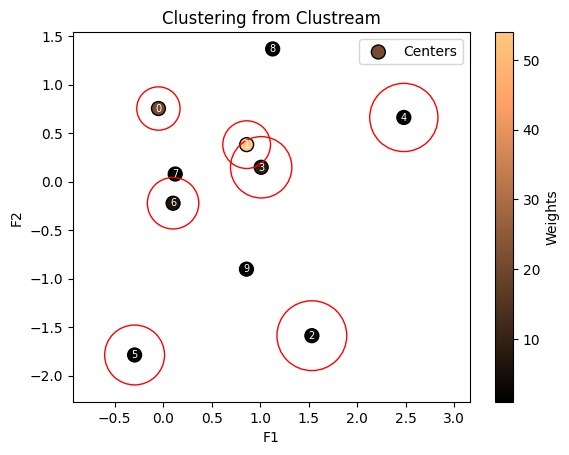

Processed 200 instances.


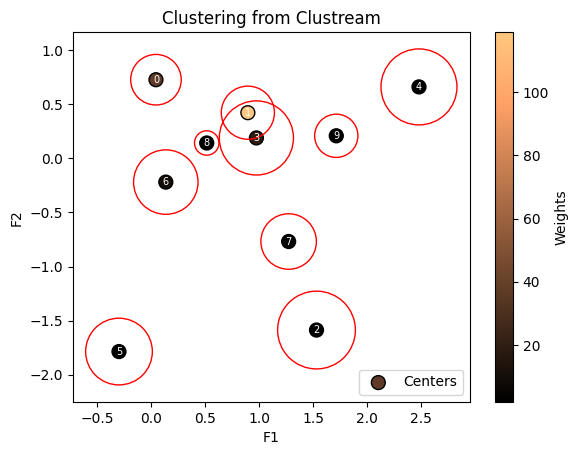

Processed 300 instances.


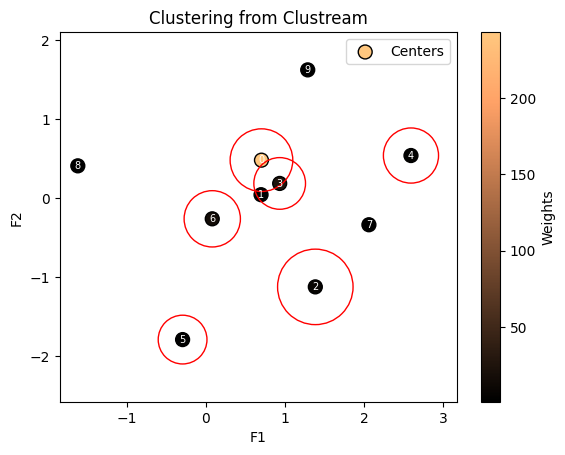

In [8]:
from capymoa.base import MOAClusterer
from capymoa.stream.generator import RandomRBFGeneratorDrift
from moa.clusterers.clustream import Clustream
from capymoa.evaluation.visualization import plot_clustering_state

stream = RandomRBFGeneratorDrift(number_of_attributes=2, number_of_centroids=10, number_of_drifting_centroids=1, magnitude_of_change=0.001)
clustream = MOAClusterer(schema=stream.get_schema(), moa_learner=Clustream, CLI="-k 10")

instancesSeen = 0
updateInterval = 100
while stream.has_more_instances() and instancesSeen < 300:
    instance = stream.next_instance()
    clustream.train(instance)
    instancesSeen += 1
    if instancesSeen % updateInterval == 0:
        print(f"Processed {instancesSeen} instances.")
        plot_clustering_state(clustream)
        # by default, plot_clustering_state only shows the image and does not save it

### 3.2. Clustering evaluator & visualization

* The evaluator object stores snapshots of evaluations from the clusterer
* In this example, the evaluator just store information about centers, radii and weights for plotting the evolution

Processed 157 instances. Saving the figure without showing it.


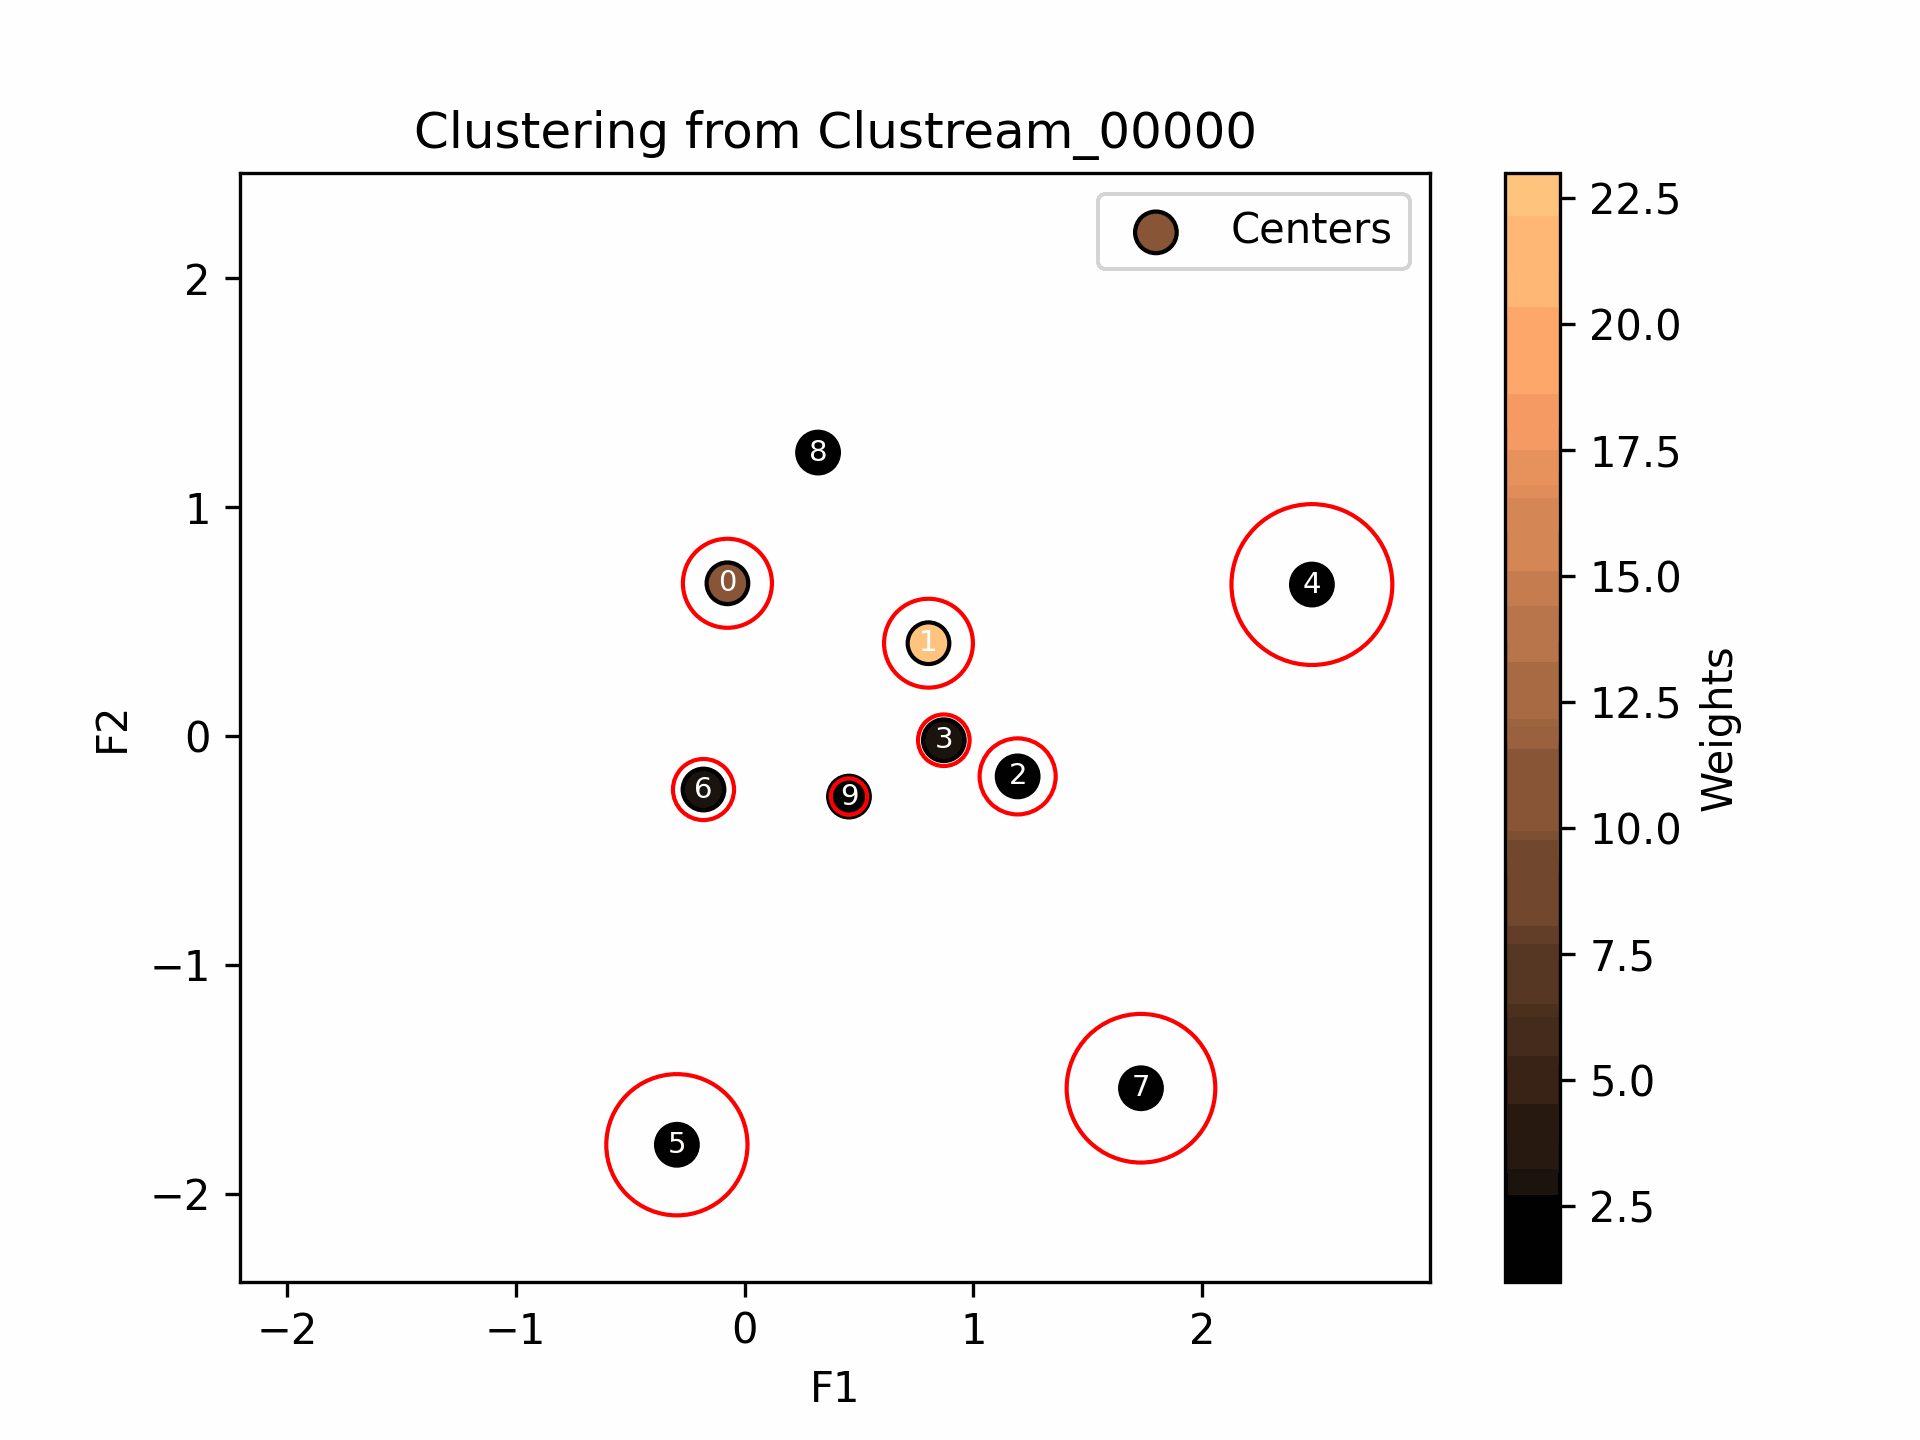

In [10]:
from capymoa.base import MOAClusterer
from capymoa.evaluation import ClusteringEvaluator
from moa.clusterers.clustream import Clustream
from capymoa.evaluation.visualization import plot_clustering_state, plot_clustering_evolution
from capymoa.stream.generator import RandomRBFGeneratorDrift
from IPython.display import Image

stream = RandomRBFGeneratorDrift(number_of_attributes=2, number_of_centroids=10, number_of_drifting_centroids=1, magnitude_of_change=0.001)
clustream = MOAClusterer(schema=stream.get_schema(), moa_learner=Clustream, CLI="-k 10")
evaluator = ClusteringEvaluator(update_interval=50)


while stream.has_more_instances() and evaluator.get_instances_seen() < 1000:
    instance = stream.next_instance()
    clustream.train(instance)
    evaluator.update(clustream)
    instancesSeen = evaluator.get_instances_seen()
    # purposefully arbitrary number
    if instancesSeen == 157:
        # can also skip show and only save
        print(f"Processed {instancesSeen} instances. Saving the figure without showing it.")
        plot_clustering_state(clustream, show_fig=False, save_fig=True, figure_name='save_fig_dont_show')

# This will save the clusterer as output
plot_clustering_evolution(evaluator, clean_up=True)

# Display the GIF
Image(filename='./output.gif')

# Do you want more?

See the tutorials at [https://capymoa.org/tutorials.html](https://capymoa.org/tutorials.html). You might be interested on notebooks: 

* [Using sklearn with CapyMOA](https://capymoa.org/notebooks/02_sklearn.html): `02_sklearn.ipynb`
* [Using Pytorch with CapyMOA](https://capymoa.org/notebooks/03_pytorch.html): `03_pytorch.ipynb`
* [Creating a new classifier in CapyMOA](https://capymoa.org/notebooks/05_new_learner.html): `05_new_learner.ipynb`
* [Parallel Ensembles](https://capymoa.org/notebooks/parallel_ensembles.html): `parallel_ensembles.ipynb`
* and much more!


### Questions/Comments? 
* Join our Discord channel: https://discord.gg/RekJArWKNZ
* Reach out on GitHub: https://github.com/adaptive-machine-learning/CapyMOA 